In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [38]:
B = 7
def create_base_learner():
    model = DecisionTreeClassifier(max_depth=2)
    return model

In [39]:
df = 10
n = 10000

X = np.pow(np.random.normal(size=(n, df)), 2)
y = (X.sum(axis=1) > np.median(X.sum(axis=1))).astype(int) * 2 - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
def predict(ensemble, X):
    y_pred = []
    for i in range(len(ensemble)):
        y_pred_i = ensemble[i][0].predict(X)
        y_pred.append(y_pred_i)
    y_pred = np.vstack(y_pred).reshape((-1, len(ensemble)))
    betas = np.array([x[1] for x in ensemble])
    y_1_val = np.sum((y_pred == 1).astype(int) * np.log(1 / betas), axis=1)
    y_minus1_val = np.sum((y_pred == -1).astype(int) * np.log(1 / betas), axis=1)
    y_pred = (y_1_val > y_minus1_val).astype(int) * 2 - 1
    return y_pred

In [47]:
ensemble = []
acc = []
w = np.ones(len(y_train)) / len(y_train)
for i in range(B):
    bl = create_base_learner()
    bl.fit(X_train, y_train, w)
    y_train_pred = bl.predict(X_train)
    fail_idx = y_train != y_train_pred
    eps = w[fail_idx].sum()
    beta = eps / (1 - eps)
    ensemble.append((bl, beta))
    w[~fail_idx] *= beta
    w /= w.sum()

    print(sum(fail_idx))

    y_test_pred = predict(ensemble, X_train)
    acc.append((y_train == y_test_pred).astype(int).sum() / y_train.shape[0])

0.7217500000000002
2887
0.7456720919820302
2828
0.7459214525505414
2852
0.679706710818345
4010
0.6572117108697465
2884
0.7031991603930468
2960
0.7402530265511025
4010


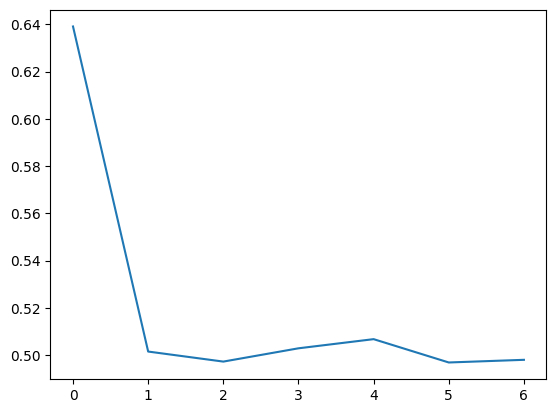

In [46]:
plt.plot(acc)